In [1]:
from SimpleSeparatorExperiment import *
from PartImageNetAgg import *
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from SimpleSeparatorExperiment import *
from statistics import fmean
from torch.utils.data import random_split

In [2]:
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [47]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model.fc = torch.nn.Linear(512, 11)
model.register_parameter(name='alpha', param=torch.nn.Parameter(torch.randn(2)))
# model.layer4.register_forward_hook(get_features("embedding"))

model.to(device)

Using cache found in C:\Users\goate/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\goate\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\goate\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
mean = [0.4680, 0.4485, 0.3801]
std = [0.2604, 0.2521, 0.2568]

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

dataset = PartImageNetAgg(root_folder='.', transform=transforms)
trainset, testset = random_split(dataset, [0.7, 0.3])

Zip Archive already extracted
Loaded: .\annotations.json


In [5]:
print(f'dataset length: {len(dataset)}')

dataset length: 13164


Text(0.5, 1.0, 'Class distibution')

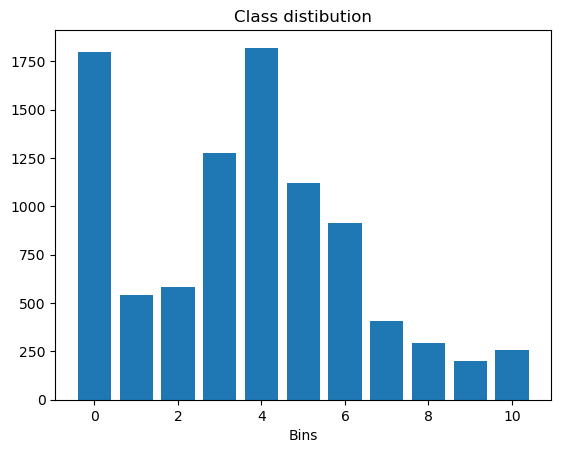

In [6]:
dloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

_, _, y = next(iter(dloader))

bins = 11

hist, bin_edges = torch.histogram(y.float(), bins=bins)

x = range(bins)

plt.bar(x, hist, align='center')
plt.xlabel('Bins')
plt.title('Class distibution')

In [7]:
weights = 1/hist # this is done in order to weight the data so that we can have a uniform probability of sampling each class in a batch
weights

samples_weights = torch.tensor([weights[int(t)] for t in y.numpy()])

In [8]:
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(trainset), replacement=True)

In [9]:
trainloader = DataLoader(trainset, batch_size=256, sampler=sampler)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

In [10]:
def devide_parts(parts, image):
    unique_parts = torch.vstack([img.unique() for img in parts.flatten(start_dim=1)])[:, :-1] # this creates a matrix of parts without the background
    batch_size, n_parts =  unique_parts.size()
    img_size = parts.size()[-1] # valid without the width because we have square images

    # following part just in order to create a mask of the batch of images
    unique_parts = unique_parts.reshape(batch_size, -1, 1, 1)
    unique_parts = unique_parts.expand(batch_size, -1, 112, 112)

    mask = unique_parts == parts.repeat(1, n_parts, 1, 1)
    mask = mask.reshape(batch_size, n_parts, 1, img_size, img_size)
    mask = mask.repeat(1, 1, 3, 1, 1)

    image = image.reshape(batch_size, 1, -1, img_size, img_size)
    image = image.repeat(1, 2, 1, 1, 1)

    return image*mask

In [11]:
def imshow(imgs):
    # Number of images
    n = imgs.shape[0]
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2))
    
    # If there's only one image, axes won't be a list, so we handle that case
    if n == 1:
        axes = [axes]
    
    for i in range(n):
        npimg = imgs[i].numpy()
        axes[i].axis("off")
        axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
    
    plt.show()

In [12]:
lossfunc = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct = 0
        for x, _, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            correct += (torch.argmax(out, axis=1) == y).sum()
        return float(correct/len(dataloader.dataset))

def train(model, optimizer, trainloader, testloader, lossfunc, epochs=10):
    loss = []
    test_accuracy = []

    best_accuracy = 0

    for epoch in tqdm(range(epochs)):
        losses_per_epoch = []
        accuracy = get_accuracy(model, testloader)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best-resnet18.pt')

        test_accuracy.append(accuracy)

        model.train()
        for x, xs, y in iter(trainloader):

            y = y.to(device)
            
            parts = devide_parts(xs, x)

            parts = parts.to(device)
            x = x.to(device)

            model.eval()
            model(x)
            whole_embed = features["embedding"].detach().clone()
            model(parts[:, 0])
            emb0 = features["embedding"].detach().clone()
            model(parts[:, 1])
            emb1 = features["embedding"].detach().clone()
            model.train()

            out = model(x)

            l = lossfunc(out, y) # + torch.norm(((model.alpha[0]*emb0 + model.alpha[1]*emb1) - whole_embed), dim = 1).mean()
            losses_per_epoch.append(l)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        loss.append(fmean(losses_per_epoch))
    
    return (loss, test_accuracy)

In [12]:
train_loss, test_accuracy = train(model=model, optimizer=optimizer, trainloader=trainloader, testloader=testloader, lossfunc=lossfunc, epochs=100)

100%|██████████| 100/100 [48:14<00:00, 28.94s/it]


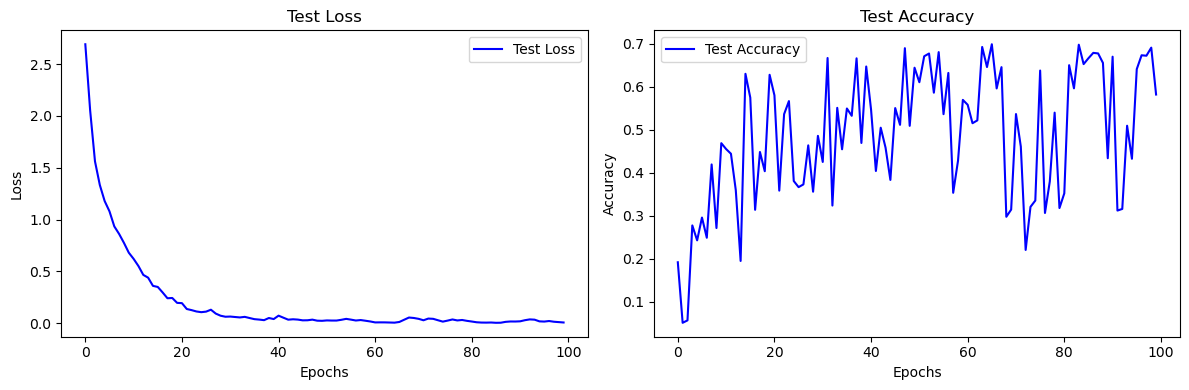

In [13]:
display_losses_and_accuracies(train_loss, test_accuracy, 100)

In [50]:
model.load_state_dict(torch.load('best-resnet18-emb-0.pt'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
def get_labels_and_predictions(model, dataloader):
    model.eval()

    batch_size = dataloader.batch_size

    predictions = torch.empty(len(dataloader.dataset), dtype=torch.uint8)
    labels = torch.empty(len(dataloader.dataset), dtype=torch.uint8)

    with torch.no_grad():
        for i, (x, _, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            out = torch.argmax(out, axis=1)

            predictions[i*batch_size:(i+1)*batch_size] = out.cpu()
            labels[i*batch_size:(i+1)*batch_size] = y.cpu()
            
    return labels.tolist(), predictions.tolist()

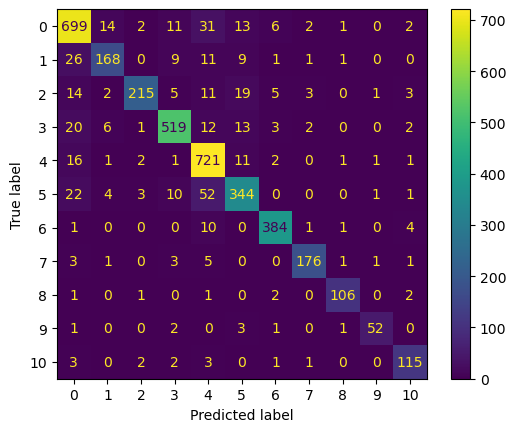

In [52]:
y , pred_y = get_labels_and_predictions(model, testloader)

cf_matrix = confusion_matrix(y, pred_y, labels=[*range(11)])
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=[*range(11)])
disp.plot()
plt.show()

In [53]:
print(f'accuracy: {np.trace(cf_matrix)/cf_matrix.sum() : .3f}')

accuracy:  0.886


In [54]:
print(f'Non zero terms: {torch.count_nonzero(model.fc.weight.detach().cpu() < 1e-6)/(11*512) : 0.3f}')

Non zero terms:  0.506


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


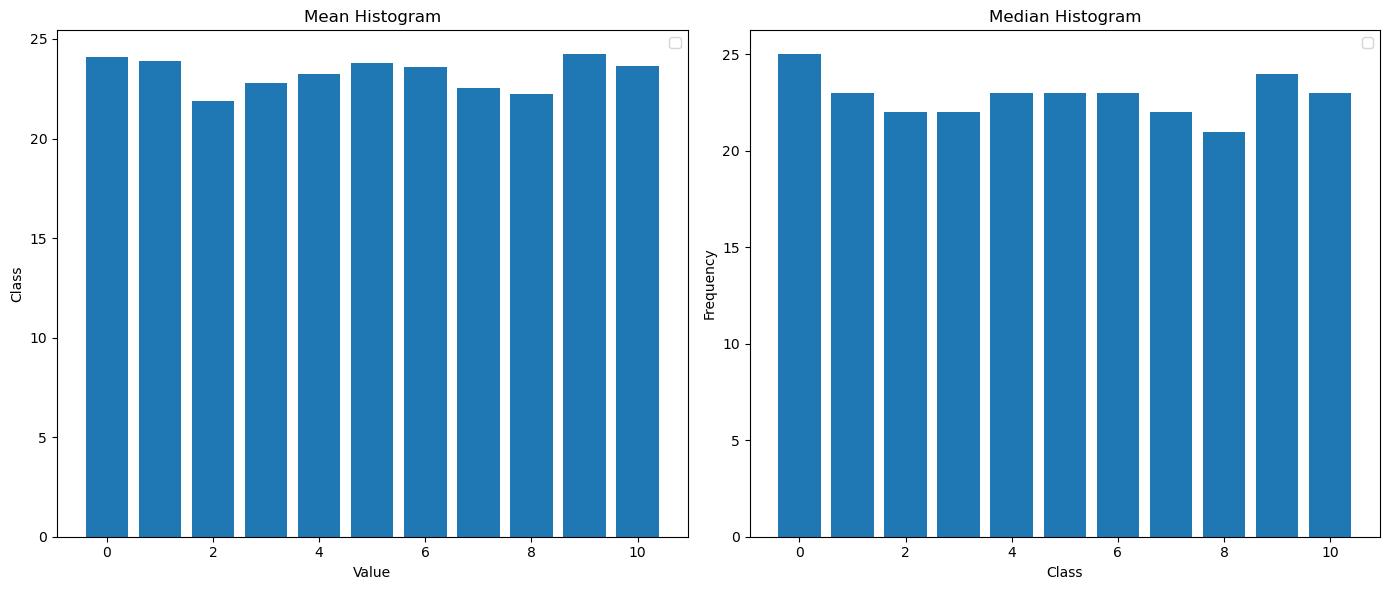

In [ ]:
def visualize_batch_statistics(dl):
    batches_data = []
    bins = 11
    for i, (_, _, y) in enumerate(dl):
        batch_hist, _ = torch.histogram(y.float(), bins=bins)
        batches_data.append(batch_hist)
    
    batches_data = torch.vstack(batches_data)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot histogram with mean on the first subplot
    axs[0].bar(range(bins), batches_data.mean(dim=0))
    axs[0].set_title('Mean Histogram')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Class')
    axs[0].legend()

    # Plot histogram with median on the second subplot
    axs[1].bar(range(bins), batches_data.median(dim=0)[0])
    axs[1].set_title('Median Histogram')
    axs[1].set_xlabel('Class')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()

    # Adjust spacing between plots
    plt.tight_layout()

    # Show plot
    plt.show()

    return batches_data

batches_data = visualize_batch_statistics(trainloader)